In [1]:

import warnings
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn import ensemble
from sklearn.svm import NuSVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import time
from numba import prange
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")


In [2]:
MODELS = {DecisionTreeRegressor, ensemble.ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, NuSVR, ExtraTreeRegressor,
          LinearRegression, BayesianRidge, KNeighborsRegressor, XGBRegressor, XGBRFRegressor, MLPRegressor, LassoLarsIC, LGBMRegressor,
          ElasticNet, SGDRegressor, LassoLars, Lasso, LinearSVR, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor}


In [3]:
housing = pd.read_csv(r'./datasets/kc_house_data.csv').sample(5000)
quality = pd.read_csv(r'./datasets/winequality-red.csv')


In [4]:
housing


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
18994,5632500110,20140716T000000,351000.0,3,1.00,1160,10518,1.0,0,0,...,7,1160,0,1960,0,98028,47.7343,-122.220,1670,9380
14830,7625701175,20141103T000000,465000.0,4,2.00,2000,6250,1.5,0,0,...,7,1480,520,1930,0,98136,47.5532,-122.389,1110,6250
4808,8650300190,20140521T000000,567000.0,3,2.50,2540,6093,2.0,0,0,...,9,2540,0,1999,0,98034,47.7042,-122.236,2540,5924
12602,9315100210,20150217T000000,227490.0,3,1.75,1820,7194,1.0,0,0,...,7,1820,0,1967,0,98003,47.3352,-122.307,1420,7560
19524,3306200230,20150303T000000,147000.0,3,1.50,1480,9606,1.0,0,0,...,7,1100,380,1964,0,98023,47.2978,-122.363,1600,9619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7797,9432900040,20140729T000000,325000.0,4,2.50,2230,8500,2.0,0,0,...,8,2230,0,1994,0,98022,47.2082,-122.009,2270,8770
20440,6056111430,20150113T000000,335000.0,2,1.75,1270,1685,2.0,0,0,...,8,1270,0,2012,0,98108,47.5646,-122.295,1270,1843
20265,7853361410,20140530T000000,545000.0,4,2.50,2720,4738,2.0,0,0,...,8,2720,0,2012,0,98065,47.5150,-121.869,2590,5740
13446,3300790540,20150109T000000,292500.0,3,2.25,1690,7320,2.0,0,0,...,7,1690,0,1987,0,98198,47.3889,-122.316,1520,7450


In [5]:
quality


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
housing = housing.dropna()
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 18994 to 21109
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [7]:
quality.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
def metrics(tt, tp, vt, vp, model,
            time=None): return {
    "model": model,
    'time': time,
    "mse": (mean_squared_error(tt, tp),
            mean_squared_error(vt, vp)),
    'r2': (r2_score(tt, tp),
           r2_score(vt, vp))
}


def create_model(X, y, model_name,
                 time_it: bool = False):
    model = model_name()
    if time_it == True:
        begin = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        return (model, end - begin)
    return model.fit(X, y)


def get_metrics(model_name):
    Xt, Xv, yt, yv = train_test_split(
        housing_X, housing_y, train_size=.7)
    results = create_model(Xt, yt, model_name, time_it=True)
    model, time = results[0], results[1]
    return metrics(
        yt, model.predict(Xt), yv,
        model.predict(Xv), model_name, time)


def get_results(X, y, models):
    results = []
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        res = executor.map(get_metrics, models)
        results = [i for i in res if i]
    return results


def plot_results(results: 'list[dict]'):
    y = [i['model'] for i in results]
    pos = np.arange(len(y))
    plt.barh(pos, [i['mse'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Validation')
    plt.show()
    plt.barh(pos, [i['mse'][0] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Traning')
    plt.show()
    plt.barh(pos, [i['time'] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Time')
    plt.show()
    plt.barh(pos, [i['r2'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('R2')
    plt.show()
    plt.barh(pos, [i['time'] * i['mse'][1] * -
             1 for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Efficiency (Higher the better)')
    plt.show()
    plt.barh(pos, [-1 * i['time'] * i['mse'][1] / (i['mse']
             [1] - i['mse'][0]) for i in results], align='center')
    plt.yticks(pos, y)
    plt.title('Weighted Efficiency (Higher the better)')
    plt.show()


In [9]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 18994 to 21109
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [10]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [11]:
housing_y


18994    351000.0
14830    465000.0
4808     567000.0
12602    227490.0
19524    147000.0
           ...   
7797     325000.0
20440    335000.0
20265    545000.0
13446    292500.0
21109    315000.0
Name: price, Length: 5000, dtype: float64

In [12]:
housing_X = MinMaxScaler().fit_transform(
    RobustScaler().fit_transform(housing_X))


In [13]:
housing_results = get_results(
    housing_X, housing_y, MODELS)


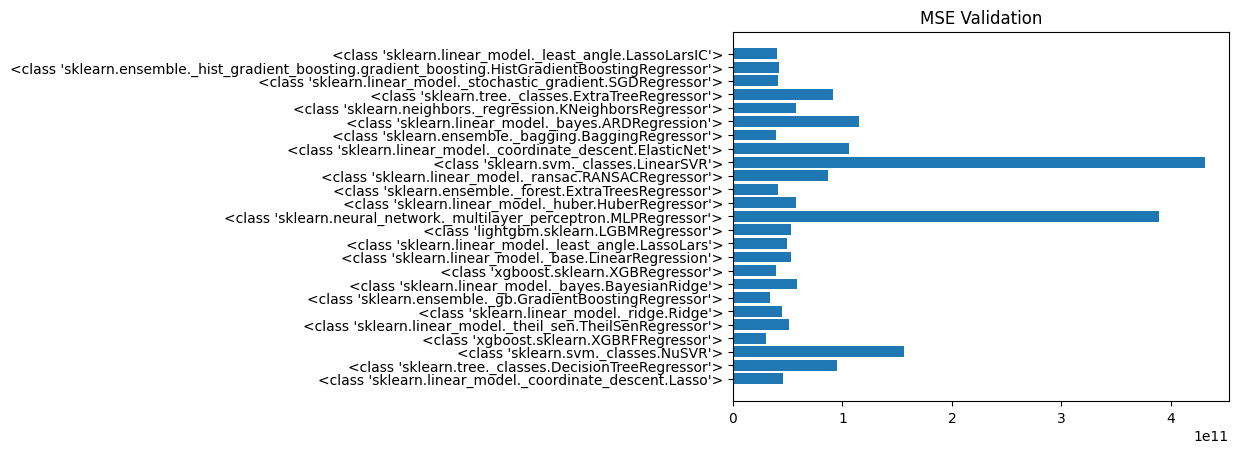

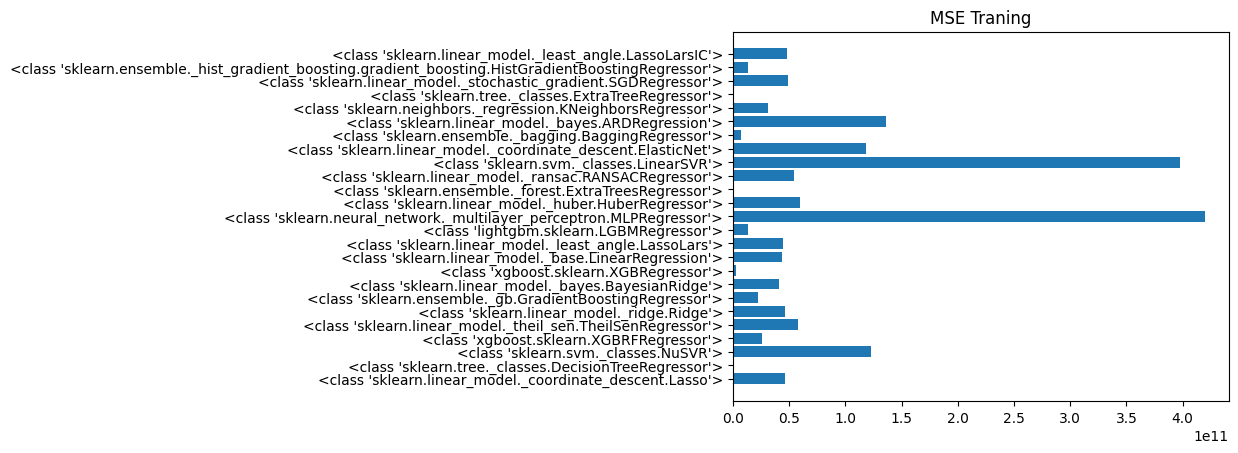

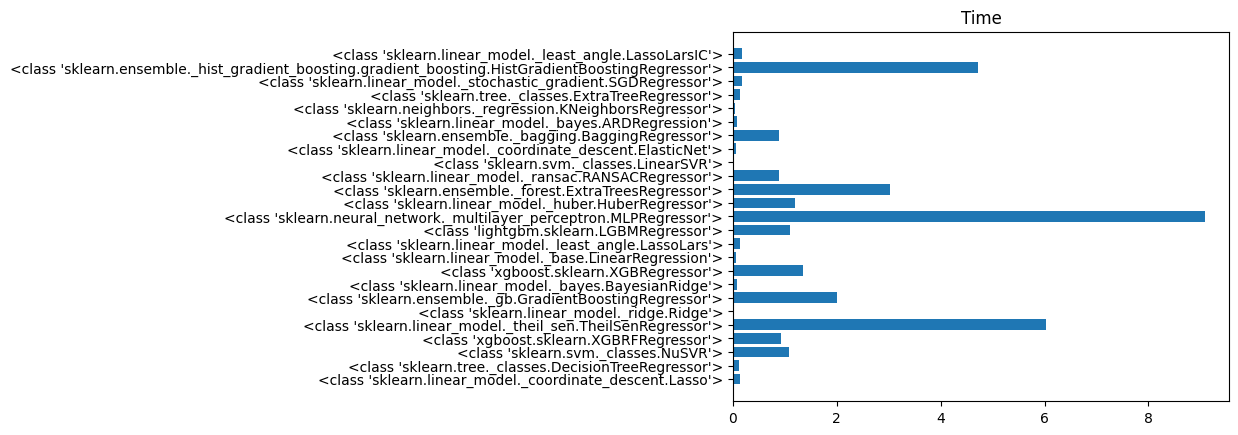

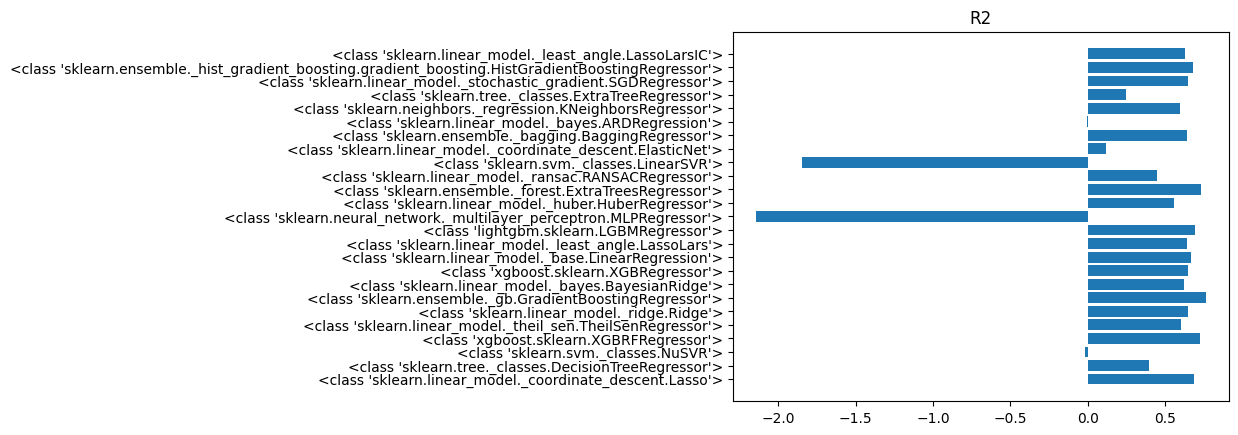

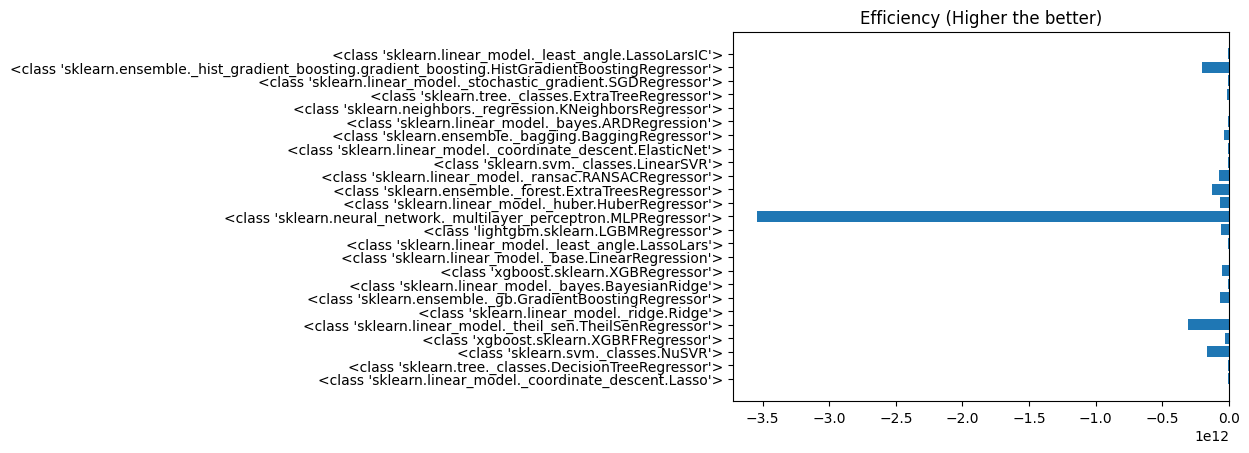

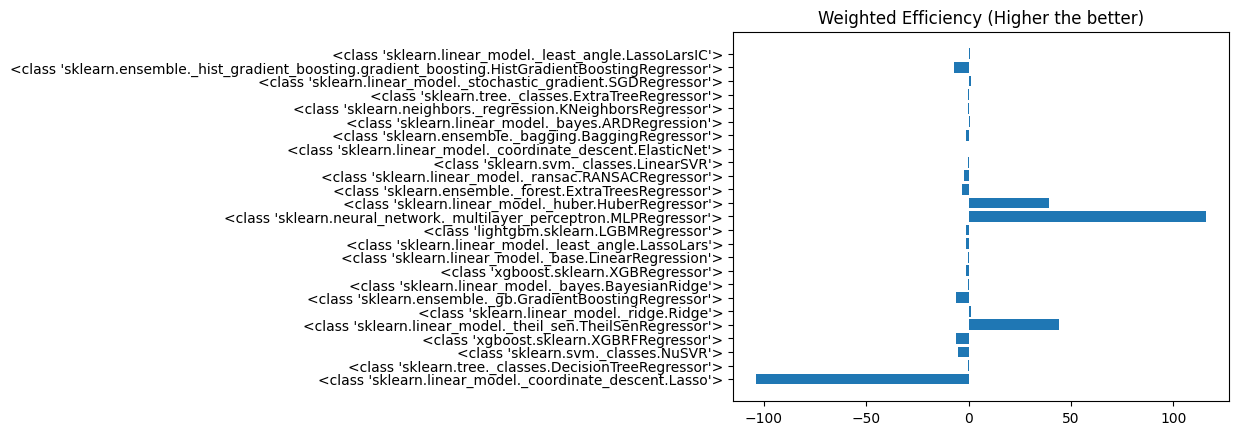

In [14]:
plot_results(housing_results)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    quality_X, quality_y, stratify=quality_y, train_size=.7)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)


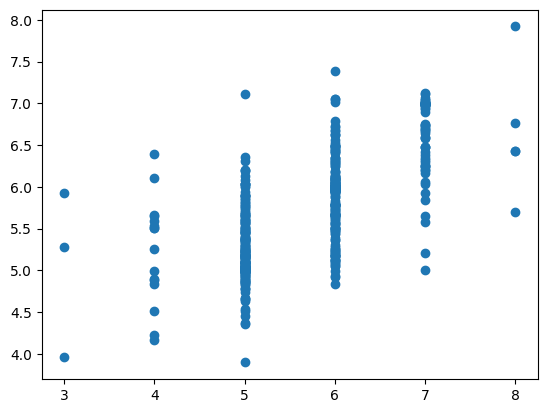

In [16]:
plt.scatter(y_val, preds)


In [17]:
mean_squared_error(y_val, preds), mean_squared_log_error(
    y_val, preds), mean_absolute_error(y_val, preds)


(0.3862497406819917, 0.009236513258704957, 0.42037875652313234)

In [18]:
mean_squared_error(y_train, xgb.predict(X_train)), mean_squared_log_error(
    y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train))


(0.0011314311801185794, 2.66014316375081e-05, 0.021870696619219605)

In [19]:
xgb.score(X_val, y_val)


0.4042380568828059

In [20]:
xgb.score(X_train, y_train)


0.9982679497110729

In [21]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [22]:
from numpy import full
from pandas import DataFrame, concat
from numba import prange
from concurrent.futures import ThreadPoolExecutor
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import NuSVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from time import perf_counter
from copy import deepcopy


class VGBRegressor(object):
    """_summary_

    Args:
        object (_type_): _description_
    """
    def __init__(self):
        """ Initialize VGBRegressor Object
        """
        self._ensemble = []

    def _metrics(self, vt, vp, model, time=None):
        """_summary_

        Args:
            vt (_type_): _description_
            vp (_type_): _description_
            model (_type_): _description_
            time (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        if self.custom_loss_metrics:
            return {'model': model, 'time': time, 'loss': self.custom_loss_metrics(vt, vp)}
        return {"model": model, "time": time, "loss": mean_squared_error(vt, vp)}

    def _create_model(self, X, y, model_name, time_it: bool = False):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_): _description_
            model_name (_type_): _description_
            time_it (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        model = model_name()
        if time_it:
            begin = perf_counter()
            model.fit(X, y)
            end = perf_counter()
            return (model, end - begin)
        return (model.fit(X, y), None)

    def _get_metrics(self, model_name):
        """_summary_

        Args:
            model_name (_type_): _description_

        Returns:
            _type_: _description_
        """
        try:
            Xt, Xv, yt, yv = train_test_split(self._X, self._y)
            results = self._create_model(Xt, yt, model_name, time_it=False)
            model, time = results[0], results[1]
            return self._metrics(yv,
                                 model.predict(Xv), model, time)
        except Exception:
            return None

    def _get_results(self, X, y) -> list:
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_): _description_

        Returns:
            list: _description_
        """
        results = []
        # self._X = self._minimax.fit_transform(self._robust.fit_transform(
        #         KNNImputer(weights='distance').fit_transform(X)))
        self._X = X
        self._y = y
        with ThreadPoolExecutor(max_workers=len(self._models)) as executor:
            res = executor.map(self._get_metrics, self._models)
            results = [i for i in res if i]
        return results

    def fit(
        self, X_train, y_train,
        early_stopping: bool = False,
        early_stopping_min_delta: float = 0.001,
        early_stopping_patience: int = 10,
        custom_models: list = None,
        learning_rate: float = 0.05,
        n_estimators: int = 100,
        warm_start: bool = False,
        complexity: bool = False,
        light: bool = True,
        custom_loss_metrics: object = False,
    ):
        """_summary_

        Args:
            X_train (_type_): _description_
            y_train (_type_): _description_
            early_stopping (bool, optional): _description_. Defaults to False.
            early_stopping_min_delta (float, optional): _description_. Defaults to 0.001.
            early_stopping_patience (int, optional): _description_. Defaults to 10.
            custom_models (list, optional): _description_. Defaults to None.
            learning_rate (float, optional): _description_. Defaults to 0.05.
            n_estimators (int, optional): _description_. Defaults to 100.
            warm_start (bool, optional): _description_. Defaults to False.
            complexity (bool, optional): _description_. Defaults to False.
            custom_loss_metrics (object, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if custom_models:
            self._models = custom_models
        self.custom_loss_metrics = custom_loss_metrics
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.early_stopping = early_stopping
        self.early_stopping_min_delta = early_stopping_min_delta
        self.early_stopping_patience = early_stopping_patience
        if custom_models:
            self._models = custom_models
        else:
            if complexity:
                self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, HistGradientBoostingRegressor,
                                ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, ExtraTreesRegressor,
                                BaggingRegressor, NuSVR, XGBRegressor, SGDRegressor, KernelRidge, MLPRegressor, LGBMRegressor,
                                Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC)
            elif light:
                self._models = (LGBMRegressor, ExtraTreeRegressor, BaggingRegressor, RANSACRegressor, LassoLarsIC, BayesianRidge)
            else:
                self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, LGBMRegressor,
                                ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor, ExtraTreesRegressor,
                                Ridge, ARDRegression, RANSACRegressor, LassoLarsIC)
        X_train = KNNImputer(weights='distance', n_neighbors=10).fit_transform(deepcopy(X_train))
        self._y_mean = y_train.mean()
        # base model: mean
        # computer residuals: y - y hat
        # for n_estimators: a) y = prev residuals && residuals * learning rate
        # add early stopping
        # restore best weights
        # ada boost and adaptive scaling for learning rates

        preds = DataFrame(
            data={'yt': y_train, 'p0': full((len(y_train)), y_train - self._y_mean)})
        residuals = DataFrame(
            data={'r0': y_train - self._y_mean})
        errors = []
        if not early_stopping:
            if warm_start:
                for i in prange(1, self.n_estimators + 1):
                    y = residuals[f'r{i - 1}']
                    results = self._get_results(X_train, y)
                    min_loss = min(results, key=lambda x: x.get(
                        "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
                    min_model = [i['model']
                                 for i in results if min_loss >= i['loss']][0]
                    preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
                        X_train) * self.learning_rate
                    residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
                    if i % 3 == 0:
                        X_train[f"r{i}"] = residuals[f'r{i}'].copy()
                    try:
                        errors.append(mean_squared_error(
                            preds['yt'], preds[f'p{i}']))
                    except Exception:
                        df = concat(
                            [preds['yt'], preds[f'p{i - 1}']], axis=1).dropna()
                        errors.append(mean_squared_error(
                            df['yt'], df[f"p{i - 1}"]))
                    self._ensemble.append(min_model)
            else:
                for i in prange(1, self.n_estimators + 1):
                    y = residuals[f'r{i - 1}']
                    results = self._get_results(X_train, y)
                    min_loss = min(results, key=lambda x: x.get(
                        "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
                    min_model = [i['model']
                                 for i in results if min_loss >= i['loss']][0]
                    preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
                        X_train) * self.learning_rate
                    residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
                    errors.append(mean_squared_error(
                        preds['yt'], preds[f'p{i}']))
                    self._ensemble.append(min_model)
                    if errors[i - 1] == 0:
                        break
        else:
            return "TODO"
        min_error = min(errors)
        min_error_i = [i for i in prange(
            len(errors)) if errors[i] == min_error][0]
        self._ensemble, errors = self._ensemble[:
                                                min_error_i], errors[:min_error_i]
        residuals = residuals[:len(errors)]
        return self._ensemble, (residuals, errors)
    
    def predict(self, X_test):
        """_summary_

        Args:
            X_test (_type_): _description_

        Returns:
            _type_: _description_
        """
        try: val = self._ensemble[0]
        except Exception:
            return "Please train the model first"
        # X_test = self._robust.transform(self._minimax.transform(deepcopy(X_test)))
        preds = DataFrame(
            data={'p0': full((len(X_test)), self._y_mean)})
        for i in prange(len(self._ensemble)):
            preds[f"p{i}"] = self._ensemble[i].predict(X_test)
        preds_ = preds.sum(axis=1)
        return preds_
    
    def score(self, X_test, y_true):
        """
        Args:
            X_test (Iterable)
            y_true (Iterable)

        Returns:
            float: R2 Score for y_true and y_predicted
        """
        return r2_score(y_true, self.predict(X_test))

    def get_params(self):
        return self.__dict__

In [23]:
# from VGBoost import VGBRegressor


In [24]:
import warnings
warnings.filterwarnings("ignore")


In [25]:
model = VGBRegressor()


In [26]:
models = model.fit(X_train, y_train, light=False)


In [713]:
model.get_params()

{'_ensemble': [BaggingRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 'custom_loss_metrics': False,
 'learning_rate': 0.05,
 'n_estimators': 100,
 'early_stopping': False,
 'early_stopping_min_delta': 0.001,
 'early_stopping_patience': 10,
 '_models': (sklearn.tree._classes.DecisionTreeRegressor,
  sklearn.linear_model._base.LinearRegression,
  sklearn.linear_model._bayes.BayesianRidge,
  sklearn.neighbors._regression.KNeighborsRegressor,
  lightgbm.sklearn.LGBMRegressor,
  sklearn.linear_model._coordinate_descent.ElasticNet,
 

In [714]:
models, res, errors = models[0], models[1][0], models[1][1]

<AxesSubplot: >

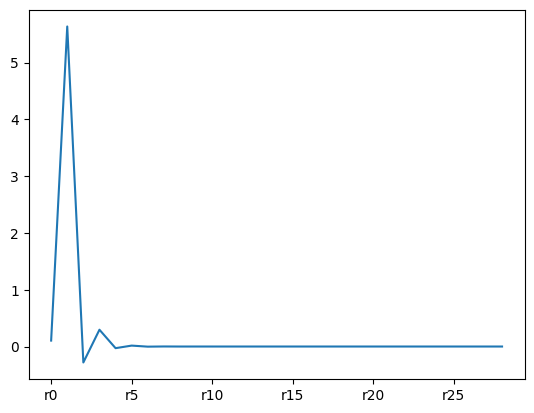

In [715]:
res.mean().plot()


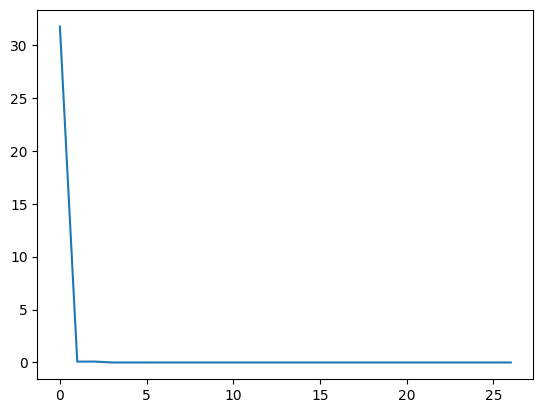

In [716]:
plt.plot(errors)


In [717]:
errors, models


([31.75560630495594,
  0.07939426777120842,
  0.08749767043860018,
  0.0008325868628064379,
  0.0002634679117272626,
  5.080397075723171e-06,
  8.542507569087031e-07,
  2.5250718095573283e-08,
  2.9330213024375675e-09,
  1.1348540876509706e-10,
  1.0500825117065076e-11,
  4.825648538671657e-13,
  3.871364466892208e-14,
  1.986595947214181e-15,
  1.4559899760293942e-16,
  8.01955610733624e-18,
  5.548995754233182e-19,
  3.198369016008766e-20,
  2.133311680046088e-21,
  1.2659370693909562e-22,
  8.248087713638873e-24,
  4.986488870656873e-25,
  3.200673426164784e-26,
  1.95352291446795e-27,
  1.2212028567864087e-28,
  9.294318297081162e-30,
  7.759952112797397e-31],
 [BaggingRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegresso

In [718]:
/len errors


27

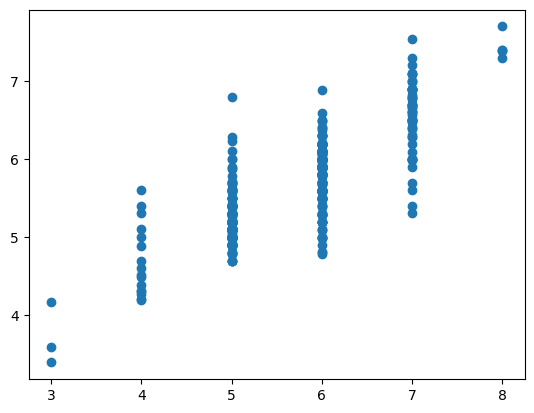

In [719]:
plt.scatter(y_val, model.predict(X_val))


In [724]:
model.score(X_val, y_val)


0.6849225874653213

In [725]:
model.score(X_train, y_train)


0.6534532871088938

In [726]:
mean_squared_error(y_val, model.predict(X_val)), mean_squared_log_error(
    y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))


(0.20427382160315816, 0.0047889114788654905, 0.31337027242142146)

In [727]:
mean_squared_error(y_train, model.predict(X_train)), mean_squared_log_error(
    y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))


(0.22637550355162478, 0.005510369318476736, 0.31804045724604585)

#Custom Models

In [253]:
model = VGBRegressor()
_ = model.fit(X_train, y_train, custom_models=(HistGradientBoostingRegressor, ExtraTreeRegressor, BaggingRegressor, RANSACRegressor, LassoLarsIC))

In [254]:
(model.score(X_val, y_val), model.score(X_train, y_train))

(0.3675593379886982, 0.7575562932274323)

In [255]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))


((0.41002961756917633, 0.4597399607709981),
 (0.15837205825930956, 0.2524150019290207))

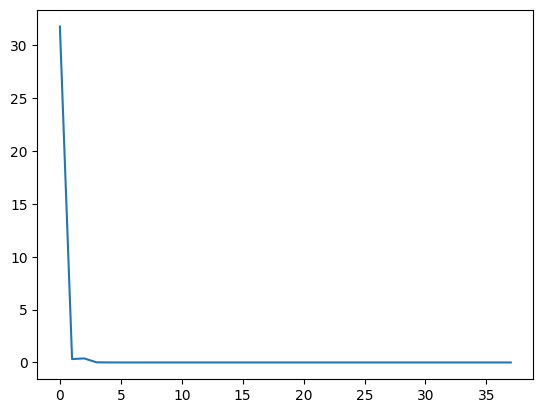

In [256]:
plt.plot(_[1][1]);

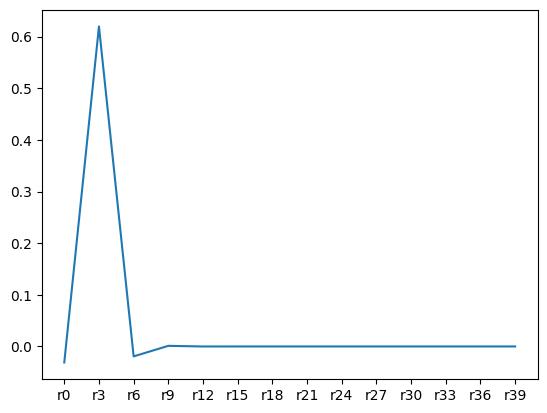

In [257]:
plt.plot(_[1][0].mean()[::3]);

In [258]:
_[0]

[BaggingRegressor(),
 HistGradientBoostingRegressor(),
 BaggingRegressor(),
 BaggingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoosti

#Complexity=True

In [136]:
model = VGBRegressor()
models = model.fit(X_train, y_train, complexity=True,)


In [137]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

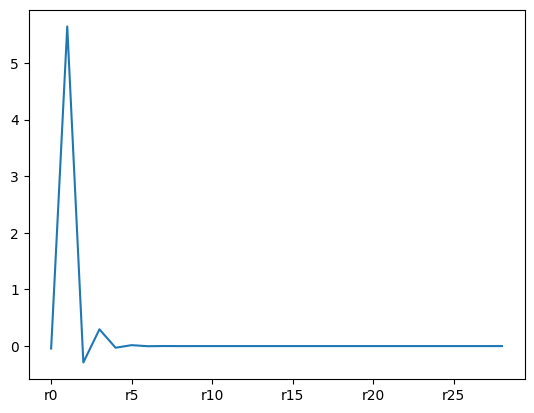

In [138]:
res.mean().plot()


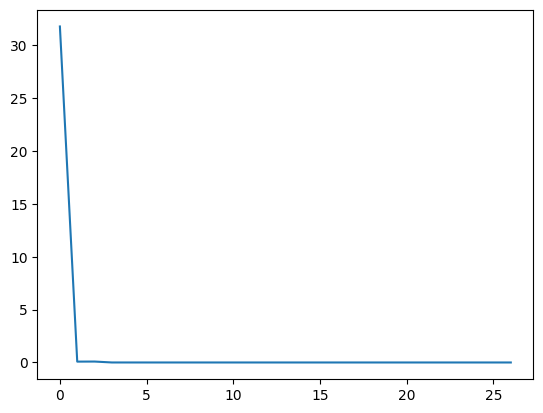

In [139]:
plt.plot(errors)


In [140]:
errors, models


([31.77921057130433,
  0.08107417904903466,
  0.0876267085111973,
  0.0008393863291957296,
  0.0002639669710668181,
  5.1083914624289636e-06,
  8.560941573980912e-07,
  2.53600850171838e-08,
  2.9405147229927073e-09,
  1.13905975694316e-10,
  1.0529385661890555e-11,
  4.842045931843545e-13,
  3.882966473483644e-14,
  1.9930288424680146e-15,
  1.4601310973299377e-16,
  8.04348284028026e-18,
  5.565124788583459e-19,
  3.20782459239774e-20,
  2.1391607962200177e-21,
  1.2695289346203193e-22,
  8.270583573185566e-24,
  5.000725344365178e-25,
  3.210027913611339e-26,
  1.9589020082320814e-27,
  1.2220752565810565e-28,
  9.343666164253164e-30,
  7.759952112797397e-31],
 [BaggingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradi

In [141]:
/len errors


27

In [142]:
model.score(X_val, y_val)


0.3891302219872663

In [143]:
model.score(X_train, y_train)


0.7800336869762146

In [144]:
mean_squared_error(y_val, model.predict(X_val)), mean_squared_log_error(
    y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))


(0.3960445880670665, 0.009589397705918457, 0.4609977037146636)

In [145]:
mean_squared_error(y_train, model.predict(X_train)), mean_squared_log_error(
    y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))


(0.1436890988223011, 0.003223025469953478, 0.2474696859185092)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    housing_X, housing_y,
    train_size=.7,
)


In [28]:
model = VGBRegressor()  # 19.6


In [29]:
models = model.fit(housing_X, housing_y, light=False)


In [30]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

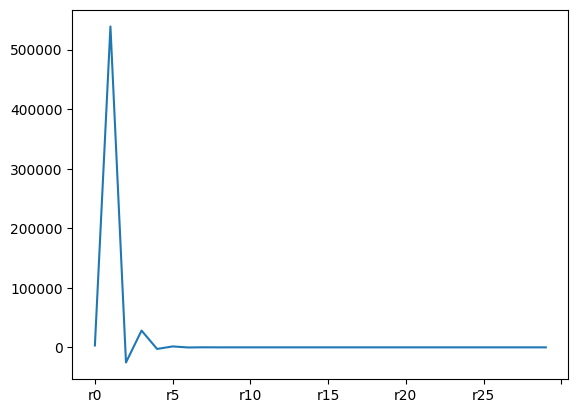

In [31]:
res.mean().plot()


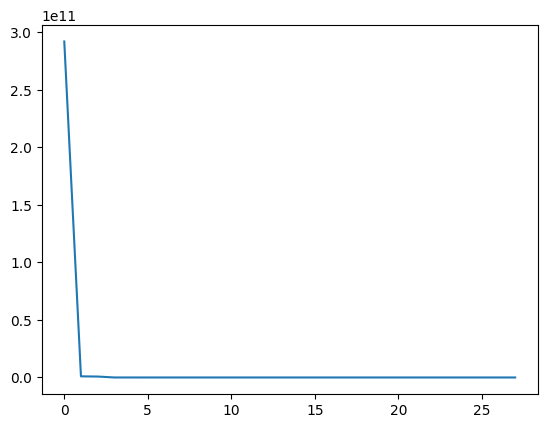

In [32]:
plt.plot(errors)


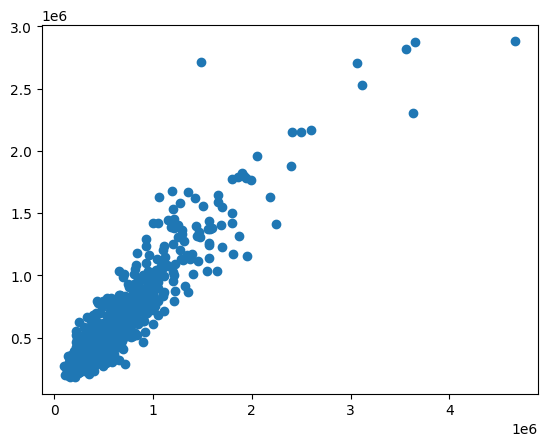

In [33]:
preds = model.predict(X_val)
plt.scatter(y_val, preds)


In [34]:
errors, models


([292106811455.82245,
  984431488.3966707,
  806612423.4571311,
  8381191.456660144,
  2436172.0762255415,
  49003.98303265179,
  7922.865395398718,
  240.01024173715282,
  27.27534012362894,
  1.0714885804135807,
  0.09786317690260789,
  0.004540951347703878,
  0.0003614306293054678,
  1.86599540995305e-05,
  1.3607762015004784e-06,
  7.524518442616127e-08,
  5.189529179217197e-09,
  2.9987794425892424e-10,
  1.9961774675026023e-11,
  1.1865490707044881e-12,
  7.720880144296597e-14,
  4.6726305306553015e-15,
  2.9966251770872196e-16,
  1.8323378694535036e-17,
  1.1876564473225397e-18,
  6.997758458576665e-20,
  2.4319586465091845e-21,
  6.467096552286583e-23],
 [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMR

In [36]:
/len errors


28

In [37]:
model.score(X_val, y_val), model.score(X_train, y_train)


(0.8501945111490026, 0.838152133760584)

In [38]:
(
    mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(
        y_val, model.predict(X_val))
), (
    mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(
        y_train, model.predict(X_train))
)


((21026550403.08867, 94695.5428587733),
 (17759319545.732765, 90812.34294732402))

#Custom Models

In [276]:
X_train, X_val, y_train, y_val = train_test_split(
    housing_X, housing_y,
    train_size=.7,
)
model = VGBRegressor()
_ = model.fit(X_train, y_train, custom_models=(HistGradientBoostingRegressor, ExtraTreeRegressor, BaggingRegressor, RANSACRegressor, LassoLarsIC))

In [277]:
(model.score(X_val, y_val), model.score(X_train, y_train))

(0.6993913254401646, 0.8936887358113713)

In [278]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))


((56861551893.91464, 133092.25429820793),
 (14208243075.391203, 71003.08876655204))

In [279]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))


((56861551893.91464, 133092.25429820793),
 (14208243075.391203, 71003.08876655204))

In [280]:
_[0], len(_[0])

([BaggingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor()

#XBG

In [281]:
X_train, X_val, y_train, y_val = train_test_split(
    housing_X, housing_y,
    train_size=.7,
)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)
model = xgb


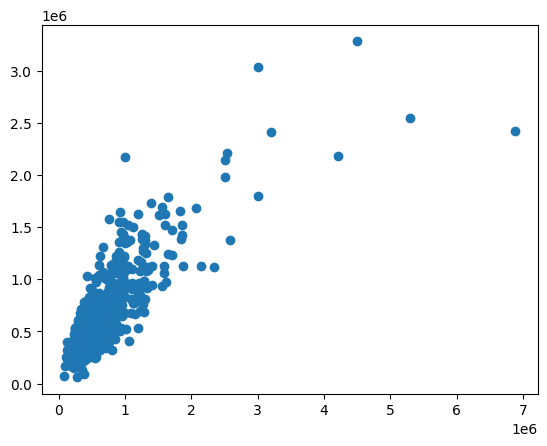

In [282]:
plt.scatter(y_val, preds)


In [289]:
(mean_squared_error(y_val, preds), mean_absolute_error(y_val, preds)), (mean_squared_error(y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train)))

((52542730262.160965, 125845.32920052084),
 (3280021331.427154, 42064.96863616072))

In [290]:
(56298665461.59785 - 16488302073.342546)/56298665461.59785


0.707128012038057

In [285]:
model.score(X_val, y_val), model.score(X_train, y_train)


(0.6750562909980493, 0.9774428159695056)

In [162]:
model = VGBRegressor()  # 19.6


In [163]:
models = model.fit(housing_X, housing_y, complexity=True)


In [164]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

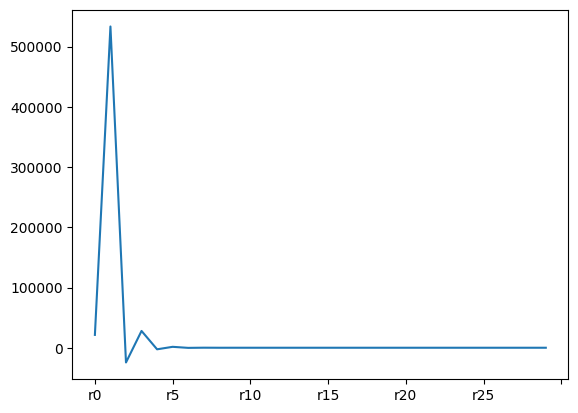

In [165]:
res.mean().plot()


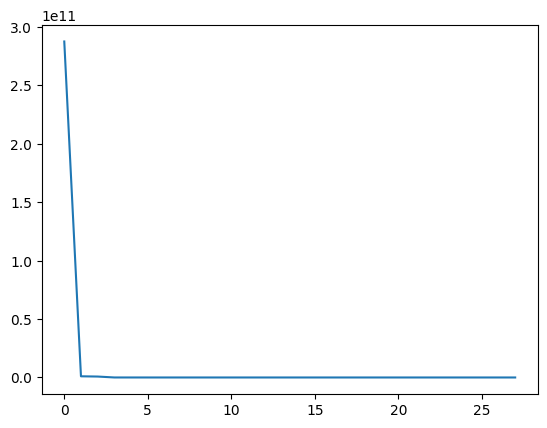

In [166]:
plt.plot(errors)


In [167]:
errors, models


([287310622832.9563,
  1010030765.4685426,
  793714816.0256798,
  8402387.762935145,
  2398471.9951817323,
  48734.41743750446,
  7807.221475920897,
  237.92974635179615,
  26.883111504692188,
  1.0579161971695696,
  0.09648509937413681,
  0.004481411863649067,
  0.00035639163074109527,
  1.8403637125543824e-05,
  1.3410528179023205e-06,
  7.419006955386846e-08,
  5.115239831807057e-09,
  2.9556268430785577e-10,
  1.9674664537276677e-11,
  1.1694672603403375e-12,
  7.611069707626532e-14,
  4.605022782260901e-15,
  2.952748867878348e-16,
  1.8080740474024942e-17,
  1.1748415588085873e-18,
  6.937492064379523e-20,
  2.3409026046793473e-21,
  4.6798570335800094e-23],
 [BaggingRegressor(),
  GradientBoostingRegressor(),
  ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1

In [168]:
/len errors


28

In [169]:
model.score(X_val, y_val), model.score(X_train, y_train)


(0.884672686799456, 0.8940026002177993)

In [170]:
(
    mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(
        y_val, model.predict(X_val))
), (
    mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(
        y_train, model.predict(X_train))
)


((13734662182.290562, 66827.64684701341),
 (14763618989.550282, 66466.41333805012))

In [171]:
(16488302073.342546 - 11046591583.660015) / 11046591583.660015 * 100


49.26144366314623

#Benchmarks


In [25]:
from sklearn.datasets import fetch_california_housing, make_friedman1, make_friedman2, make_friedman3


In [26]:
fch = fetch_california_housing(as_frame=True)['data']


In [27]:
X, y = fch.drop(['MedInc'], axis=1), fch['MedInc']


In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.7)


In [43]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)


In [44]:
((mean_squared_error(y_val, preds), mean_absolute_error(y_val, preds)), (mean_squared_error(
    y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train))))


((0.6922105043929054, 0.5748284447598069),
 (0.23620250039579363, 0.36721858749971875))

In [45]:
(xgb.score(X_val, y_val), xgb.score(X_train, y_train))


(0.8133810465451202, 0.9337606278797685)

##VGBoost


In [46]:
model = VGBRegressor()
model.fit(X_train, y_train, light=False)

([LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 (             r0        r1        r2        r3        r4        r5        r6  \
  4137   0.349685  3.863737 -0.196937  0.203446 -0.020132  0.011215 -0.001573   
  7527  -2.681015  3.948609 -0.285255  0.210818 -0.024383  0.011732 -0.001789   
  14000 -0.309615  3.834199 -0.165282  0.199526 -0.018089  0.010863 -0.001443   
  16066 -0.086915  3.881687 -0.215287  0.204326 -0.020633  0.011258 -0.001597   
  17448 -0.068615  3.884590 -0.219901  0.206805 -0.021604  0.0

In [49]:
(model.score(X_val, y_val), model.score(X_train, y_train))


(0.8162242606783999, 0.8645895676022048)

In [50]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))


((0.6816644014764596, 0.5686306169481),
 (0.4828590864958673, 0.49722860043406897))

#Complexity=True


In [51]:
model = VGBRegressor()
model.fit(X_train, y_train, complexity=True)


([HistGradientBoostingRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 (             r0        r1        r2        r3        r4        r5        r6  \
  4137   0.349685  3.866451 -0.199699  0.203706 -0.020313  0.011189 -0.001579   
  7527  -2.681015  3.943240 -0.279832  0.210736 -0.024358  0.011741 -0.001798   
  14000 -0.309615  3.833241 -0.164559  0.199750 -0.018137  0.010908 -0.001431   
  16066 -0.086915  3.865428 -0.198811  0.204052 -0.020562  0.011251 -0.001607   
  17448 -0.068615  3.882611 -0.217286  0.20680

In [52]:
(model.score(X_val, y_val), model.score(X_train, y_train))


(0.8120166217348148, 0.859815681725284)

In [53]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))


((0.6972714543589339, 0.5757949186017632),
 (0.49988225179227386, 0.5056314214635949))

##Friedman1

In [24]:
X, y = make_friedman1(n_samples=5000, noise=0.5, n_features=10)


NameError: name 'make_friedman1' is not defined

In [616]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.7)

In [478]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)


In [479]:
((mean_squared_error(y_val, preds), mean_absolute_error(y_val, preds)), (mean_squared_error(
    y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train))))


((1.0471850116789065, 0.7762178326790102),
 (0.058115235326256995, 0.1744007094410407))

In [480]:
(xgb.score(X_val, y_val), xgb.score(X_train, y_train))


(0.9607810916014041, 0.9976034158398426)

##VGb


In [401]:
from lightgbm import LGBMRegressor

In [641]:
t = perf_counter()
model = VGBRegressor()
_ = model.fit(X_train, y_train, custom_models=(HistGradientBoostingRegressor,))
print(perf_counter()-t)

30.15345520000119


In [642]:
(model.score(X_val, y_val), model.score(X_train, y_train))


(0.9674094017936401, 0.9870581527426505)

In [643]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))


((0.770214503199577, 0.6939567765851286),
 (0.30766177164338165, 0.41016637262770567))

In [644]:
_[0]

[HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 HistGradientBoostingRegressor()]

In [650]:
t = perf_counter()
model = VGBRegressor()
_ = model.fit(X_train, y_train, 
            custom_models=(LGBMRegressor,))
print(perf_counter() - t)

3.9974783999987267


In [647]:
(model.score(X_val, y_val), model.score(X_train, y_train))

(0.968474537990675, 0.9867865976555001)

In [648]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))

((0.7450421101786039, 0.6892956522764313),
 (0.3141173507852241, 0.41294546517650155))

In [649]:
_[0]

[LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor()]

In [637]:
model.get_params()

{'_ensemble': [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 '_models': (lightgbm.sklearn.LGBMRegressor,),
 'custom_loss_metrics': False,
 'learning_rate': 0.05,
 'n_estimators': 100,
 'early_stopping': False,
 'early_stopping_min_delta': 0.001,
 'early_stopping_patience': 10,
 '_y_mean': 14.276907577234994,
 '_X': array([[0.65101184, 0.36873766, 0.99314771, ..., 0.37347309, 0.79933291,
         0.97642693],
        [0.86603253, 0.12996995, 0.57323246, ..., 0.59023093, 0.71356962,
         0.4419498 ],
      

In [638]:
model.get_params()

{'_ensemble': [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 '_models': (lightgbm.sklearn.LGBMRegressor,),
 'custom_loss_metrics': False,
 'learning_rate': 0.05,
 'n_estimators': 100,
 'early_stopping': False,
 'early_stopping_min_delta': 0.001,
 'early_stopping_patience': 10,
 '_y_mean': 14.276907577234994,
 '_X': array([[0.65101184, 0.36873766, 0.99314771, ..., 0.37347309, 0.79933291,
         0.97642693],
        [0.86603253, 0.12996995, 0.57323246, ..., 0.59023093, 0.71356962,
         0.4419498 ],
      

#Classification

In [17]:
from VGBoost import VGBRegressor, VGBClassifier

In [18]:
clf = VGBClassifier()

In [6]:
from sklearn.datasets import make_classification

In [7]:
X, y = make_classification(n_samples=5000)

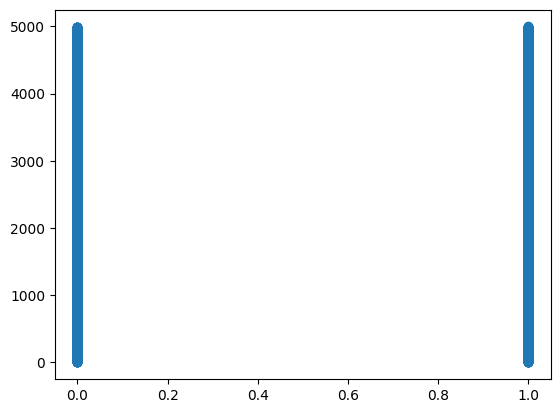

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y, [i for i in range(len(y))]);

In [9]:
from sklearn.model_selection import  train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7, stratify=y
)

In [10]:
np.log(4/2)

NameError: name 'np' is not defined

In [11]:
uniq_array,count_array = np.unique(np.array(y),axis=0, return_counts=True)

NameError: name 'np' is not defined

In [12]:
dict(zip(uniq_array,count_array))

NameError: name 'uniq_array' is not defined

In [13]:
log_odds = np.log(dict(zip(uniq_array,count_array))[1]/dict(zip(uniq_array,count_array))[0])

NameError: name 'np' is not defined

In [14]:
# import numpy as np
# from pandas import DataFrame, concat
# from numba import prange, njit
# from concurrent.futures import ThreadPoolExecutor
# # Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import RobustScaler, MinMaxScaler
# from sklearn.metrics import mean_squared_error, r2_score, f1_score
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
# from sklearn.svm import NuSVR, SVC
# from sklearn.base import BaseEstimator
# from lightgbm import LGBMRegressor
# from sklearn.neural_network import MLPRegressor
# from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor
# from sklearn.impute import KNNImputer
# from time import perf_counter
# import collections.abc
# from copy import deepcopy


# class VGBRegressor(BaseEstimator):
#     """_summary_

#     Args:
#         object (_type_): _description_
#     """

#     def __init__(self):
#         """ Initialize VGBRegressor Object
#         """
#         self._ensemble = []

#     def _metrics(self, vt, vp, model, time=None):
#         """_summary_

#         Args:
#             vt (_type_): _description_
#             vp (_type_): _description_
#             model (_type_): _description_
#             time (_type_, optional): _description_. Defaults to None.

#         Returns:
#             _type_: _description_
#         """
#         if self.custom_loss_metrics:
#             return {'model': model, 'time': time, 'loss': self.custom_loss_metrics(vt, vp)}
#         return {"model": model, "time": time, "loss": mean_squared_error(vt, vp)}

#     def _create_model(self, X, y, model_name, time_it: bool = False):
#         """_summary_

#         Args:
#             X (_type_): _description_
#             y (_type_): _description_
#             model_name (_type_): _description_
#             time_it (bool, optional): _description_. Defaults to False.

#         Returns:
#             _type_: _description_
#         """
#         model = model_name()
#         if time_it:
#             begin = perf_counter()
#             model.fit(X, y)
#             end = perf_counter()
#             return (model, end - begin)
#         return (model.fit(X, y), None)

#     def _get_metrics(self, model_name):
#         """_summary_

#         Args:
#             model_name (_type_): _description_

#         Returns:
#             _type_: _description_
#         """
#         try:
#             Xt, Xv, yt, yv = train_test_split(self._X, self._y)
#             results = self._create_model(Xt, yt, model_name, time_it=False)
#             model, time = results[0], results[1]
#             return self._metrics(yv,
#                                  model.predict(Xv), model, time)
#         except Exception:
#             return None

#     def _get_results(self, X, y) -> list:
#         """_summary_

#         Args:
#             X (_type_): _description_
#             y (_type_): _description_

#         Returns:
#             list: _description_
#         """
#         results = []
#         # self._X = self._minimax.fit_transform(self._robust.fit_transform(
#         #         KNNImputer(weights='distance').fit_transform(X)))
#         self._X = X
#         self._y = y
#         with ThreadPoolExecutor(max_workers=len(self._models)) as executor:
#             res = executor.map(self._get_metrics, self._models)
#             results = [i for i in res if i]
#         return results

#     def fit(
#         self, X_train, y_train,
#         early_stopping: bool = False,
#         early_stopping_min_delta: float = 0.001,
#         early_stopping_patience: int = 10,
#         custom_models: list = None,
#         learning_rate: float = 0.05,
#         n_estimators: int = 100,
#         warm_start: bool = False,
#         complexity: bool = False,
#         light: bool = True,
#         custom_loss_metrics: object = False,
#     ):
#         """_summary_

#         Args:
#             X_train (_type_): _description_
#             y_train (_type_): _description_
#             early_stopping (bool, optional): _description_. Defaults to False.
#             early_stopping_min_delta (float, optional): _description_. Defaults to 0.001.
#             early_stopping_patience (int, optional): _description_. Defaults to 10.
#             custom_models (list, optional): _description_. Defaults to None.
#             learning_rate (float, optional): _description_. Defaults to 0.05.
#             n_estimators (int, optional): _description_. Defaults to 100.
#             warm_start (bool, optional): _description_. Defaults to False.
#             complexity (bool, optional): _description_. Defaults to False.
#             custom_loss_metrics (object, optional): _description_. Defaults to False.

#         Returns:
#             _type_: _description_
#         """
#         if custom_models:
#             self._models = custom_models
#         self.custom_loss_metrics = custom_loss_metrics
#         self.learning_rate = learning_rate
#         self.n_estimators = n_estimators
#         self.early_stopping = early_stopping
#         self.early_stopping_min_delta = early_stopping_min_delta
#         self.early_stopping_patience = early_stopping_patience
#         if custom_models:
            
#             self._models = custom_models
#         else:
#             if complexity:
#                 self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, HistGradientBoostingRegressor,
#                                 ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, ExtraTreesRegressor,
#                                 BaggingRegressor, NuSVR, XGBRegressor, SGDRegressor, KernelRidge, MLPRegressor, LGBMRegressor,
#                                 Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC)
#             elif light:
#                 self._models = (LGBMRegressor, ExtraTreesRegressor,
#                                 BaggingRegressor, RANSACRegressor, LassoLarsIC, BayesianRidge)
#             else:
#                 self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, LGBMRegressor,
#                                 ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor, ExtraTreesRegressor,
#                                 Ridge, ARDRegression, RANSACRegressor, LassoLarsIC)
#         X_train = KNNImputer(weights='distance',
#                              n_neighbors=10).fit_transform(deepcopy(X_train))
#         self._y_mean = y_train.mean()
#         # base model: mean
#         # computer residuals: y - y hat
#         # for n_estimators: a) y = prev residuals && residuals * learning rate
#         # add early stopping
#         # restore best weights
#         # ada boost and adaptive scaling for learning rates

#         preds = DataFrame(
#             data={'yt': y_train, 'p0': np.full((len(y_train)), y_train - self._y_mean)})
#         residuals = DataFrame(
#             data={'r0': y_train - self._y_mean})
#         errors = []
#         if not early_stopping:
#             if warm_start:
#                 for i in prange(1, self.n_estimators + 1):
#                     y = residuals[f'r{i - 1}']
#                     results = self._get_results(X_train, y)
#                     min_loss = min(results, key=lambda x: x.get(
#                         "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
#                     min_model = [i['model']
#                                  for i in results if min_loss >= i['loss']][0]
#                     preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
#                         X_train) * self.learning_rate
#                     residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
#                     if i % 3 == 0:
#                         X_train[f"r{i}"] = residuals[f'r{i}'].copy()
#                     try:
#                         errors.append(mean_squared_error(
#                             preds['yt'], preds[f'p{i}']))
#                     except Exception:
#                         df = concat(
#                             [preds['yt'], preds[f'p{i - 1}']], axis=1).dropna()
#                         errors.append(mean_squared_error(
#                             df['yt'], df[f"p{i - 1}"]))
#                     self._ensemble.append(min_model)
#             else:
#                 for i in prange(1, self.n_estimators + 1):
#                     y = residuals[f'r{i - 1}']
#                     results = self._get_results(X_train, y)
#                     min_loss = min(results, key=lambda x: x.get(
#                         "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
#                     min_model = [i['model']
#                                  for i in results if min_loss >= i['loss']][0]
#                     preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
#                         X_train) * self.learning_rate
#                     residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
#                     errors.append(mean_squared_error(
#                         preds['yt'], preds[f'p{i}']))
#                     self._ensemble.append(min_model)
#                     if errors[i - 1] == 0:
#                         break
#         else:
#             return "TODO"
#         min_error = min(errors)
#         min_error_i = [i for i in prange(
#             len(errors)) if errors[i] == min_error][0]
#         self._ensemble, errors = self._ensemble[:
#                                                 min_error_i], errors[:min_error_i]
#         residuals = residuals[:len(errors)]
#         return self._ensemble, (residuals, errors)

#     def predict(self, X_test):
#         """_summary_

#         Args:
#             X_test (_type_): _description_

#         Returns:
#             _type_: _description_
#         """
#         try:
#             val = self._ensemble[0]
#         except Exception:
#             return "Please train the model first"
#         # X_test = self._robust.transform(self._minimax.transform(deepcopy(X_test)))
#         preds = DataFrame(
#             data={'p0': np.full((len(X_test)), self._y_mean)})
#         for i in prange(len(self._ensemble)):
#             preds[f"p{i}"] = self._ensemble[i].predict(X_test)
#         preds_ = preds.sum(axis=1)
#         return preds_

#     def score(self, X_test, y_true):
#         """
#         Args:
#             X_test (Iterable)
#             y_true (Iterable)

#         Returns:
#             float: R2 Score for y_true and y_predicted
#         """
#         return r2_score(y_true, self.predict(X_test))

#     def get_params(self):
#         return self.__dict__


# class VGBClassifier(BaseEstimator):
#     """_summary_

#     Args:
#         object (_type_): _description_
#     """

#     def __init__(self):
#         """ Initialize VGBRegressor Object
#         """
#         self._ensemble = []

#     def _metrics(self, vt, vp, model, time=None):
#         """_summary_

#         Args:
#             vt (_type_): _description_
#             vp (_type_): _description_
#             model (_type_): _description_
#             time (_type_, optional): _description_. Defaults to None.

#         Returns:
#             _type_: _description_
#         """
#         if self.custom_loss_metrics:
#             return {'model': model, 'time': time, 'loss': self.custom_loss_metrics(vt, vp)}
#         return {"model": model, "time": time, "loss": mean_squared_error(vt, vp)}

#     def _create_model(self, X, y, model_name, time_it: bool = False):
#         """_summary_

#         Args:
#             X (_type_): _description_
#             y (_type_): _description_
#             model_name (_type_): _description_
#             time_it (bool, optional): _description_. Defaults to False.

#         Returns:
#             _type_: _description_
#         """
#         model = model_name()
#         if time_it:
#             begin = perf_counter()
#             model.fit(X, y)
#             end = perf_counter()
#             return (model, end - begin)
#         return (model.fit(X, y), None)

#     def _get_metrics(self, model_name):
#         """_summary_

#         Args:
#             model_name (_type_): _description_

#         Returns:
#             _type_: _description_
#         """
#         try:
#             Xt, Xv, yt, yv = train_test_split(self._X, self._y)
#             results = self._create_model(Xt, yt, model_name, time_it=False)
#             model, time = results[0], results[1]
#             return self._metrics(yv,
#                                  model.predict(Xv), model, time)
#         except Exception:
#             return None

#     def _get_results(self, X, y) -> list:
#         """_summary_

#         Args:
#             X (_type_): _description_
#             y (_type_): _description_

#         Returns:
#             list: _description_
#         """
#         results = []
#         # self._X = self._minimax.fit_transform(self._robust.fit_transform(
#         #         KNNImputer(weights='distance').fit_transform(X)))
#         self._X = X
#         self._y = y
#         with ThreadPoolExecutor(max_workers=len(self._models)) as executor:
#             res = executor.map(self._get_metrics, self._models)
#             results = [i for i in res if i]
#         return results
    
#     @njit
#     def _sigmoid_function(z):
#         # https://www.geeksforgeeks.org/implement-sigmoid-function-using-numpy/
#         return 1.0/(1.0 + np.exp(-z))

#     def fit(
#         self, X_train, y_train,
#         early_stopping: bool = False,
#         early_stopping_min_delta: float = 0.001,
#         early_stopping_patience: int = 10,
#         custom_models: list = None,
#         learning_rate: float = 0.05,
#         n_estimators: int = 100,
#         warm_start: bool = False,
#         complexity: bool = False,
#         light: bool = True,
#         custom_loss_metrics: object = False,
#     ):
#         """_summary_

#         Args:
#             X_train (_type_): _description_
#             y_train (_type_): _description_
#             early_stopping (bool, optional): _description_. Defaults to False.
#             early_stopping_min_delta (float, optional): _description_. Defaults to 0.001.
#             early_stopping_patience (int, optional): _description_. Defaults to 10.
#             custom_models (list, optional): _description_. Defaults to None.
#             learning_rate (float, optional): _description_. Defaults to 0.05.
#             n_estimators (int, optional): _description_. Defaults to 100.
#             warm_start (bool, optional): _description_. Defaults to False.
#             complexity (bool, optional): _description_. Defaults to False.
#             custom_loss_metrics (object, optional): _description_. Defaults to False.

#         Returns:
#             _type_: _description_
#         """
#         if custom_models:
#             self._models = custom_models
#         self.custom_loss_metrics = custom_loss_metrics
#         self.learning_rate = learning_rate
#         self.n_estimators = n_estimators
#         self.early_stopping = early_stopping
#         self.early_stopping_min_delta = early_stopping_min_delta
#         self.early_stopping_patience = early_stopping_patience
#         if custom_models:
#             self._models = custom_models
#         else:
#             if complexity:
#                 self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, HistGradientBoostingRegressor,
#                                 ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, ExtraTreesRegressor,
#                                 BaggingRegressor, NuSVR, XGBRegressor, SGDRegressor, KernelRidge, MLPRegressor, LGBMRegressor,
#                                 Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC)
#             elif light:
#                 self._models = (LGBMRegressor, ExtraTreesRegressor,
#                                 BaggingRegressor, RANSACRegressor, LassoLarsIC, BayesianRidge)
#             else:
#                 self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, LGBMRegressor,
#                                 ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor, ExtraTreesRegressor,
#                                 Ridge, ARDRegression, RANSACRegressor, LassoLarsIC)
#         X_train = KNNImputer(weights='distance',
#                              n_neighbors=10).fit_transform(deepcopy(X_train))
#         # logistic regression
#         # log(odds)
#         uniq_array,count_array = np.unique(y_train, axis=0, return_counts=True)
#         dict_odds = dict(zip(uniq_array,count_array))
#         log_odds = np.log(dict_odds[1]/ dict_odds[0])
#         self._y_mean = (np.e ** log_odds)/(1 + (np.e ** log_odds))
#         # return self._y_mean
#         preds = DataFrame(
#             data={'yt': y_train, 'p0': np.full((len(y_train)), y_train - self._y_mean)})
#         residuals = DataFrame(
#             data={'r0': y_train - self._y_mean})
#         errors = []
#         if not early_stopping:
#             if warm_start:
#                 for i in prange(1, self.n_estimators + 1):
#                     y = residuals[f'r{i - 1}']
#                     results = self._get_results(X_train, y)
#                     min_loss = min(results, key=lambda x: x.get(
#                         "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
#                     min_model = [i['model']
#                                  for i in results if min_loss >= i['loss']][0]
#                     preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
#                         X_train) * self.learning_rate
#                     residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
#                     if i % 3 == 0:
#                         X_train[f"r{i}"] = residuals[f'r{i}'].copy()
#                     try:
#                         errors.append(mean_squared_error(
#                             preds['yt'], preds[f'p{i}']))
#                     except Exception:
#                         df = concat(
#                             [preds['yt'], preds[f'p{i - 1}']], axis=1).dropna()
#                         errors.append(mean_squared_error(
#                             df['yt'], df[f"p{i - 1}"]))
#                     self._ensemble.append(min_model)
#             else:
#                 for i in prange(1, self.n_estimators + 1):
#                     y = residuals[f'r{i - 1}']
#                     results = self._get_results(X_train, y)
#                     return results
#                     min_loss = min(results, key=lambda x: x.get(
#                         "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
#                     min_model = [i['model']
#                                  for i in results if min_loss >= i['loss']][0]
#                     preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
#                         X_train) * self.learning_rate
#                     residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
#                     errors.append(mean_squared_error(
#                         preds['yt'], preds[f'p{i}']))
#                     self._ensemble.append(min_model)
#                     if errors[i - 1] == 0:
#                         break
#         else:
#             return "TODO"
#         min_error = min(errors)
#         min_error_i = [i for i in prange(
#             len(errors)) if errors[i] == min_error][0]
#         self._ensemble, errors = self._ensemble[:
#                                                 min_error_i], errors[:min_error_i]
#         residuals = residuals[:len(errors)]
#         return self._ensemble, (residuals, errors)

#     def predict(self, X_test):
#         """_summary_

#         Args:
#             X_test (_type_): _description_

#         Returns:
#             _type_: _description_
#         """
#         try:
#             val = self._ensemble[0]
#         except Exception:
#             return "Please train the model first"
#         # X_test = self._robust.transform(self._minimax.transform(deepcopy(X_test)))
#         preds = DataFrame(
#             data={'p0': np.full((len(X_test)), self._y_mean)})
#         for i in prange(len(self._ensemble)):
#             preds[f"p{i}"] = self._ensemble[i].predict(X_test)
#         preds_ = self._sigmoid_function(preds.sum(axis=1))
#         def quantize(x):
#             if x > 0.5:
#                 return 1
#             else:
#                 return 0
#         return preds_.apply(quantize)

#     def score(self, X_test, y_true):
#         """
#         Args:
#             X_test (Iterable)
#             y_true (Iterable)

#         Returns:
#             float: R2 Score for y_true and y_predicted
#         """
#         return r2_score(y_true, self.predict(X_test))

#     def get_params(self):
#         return self.__dict__

In [15]:
from VGBoost import VGBClassifier

In [16]:
clf = VGBClassifier()

In [17]:
z = sigmoid_function(y)

NameError: name 'sigmoid_function' is not defined

In [18]:
y_train

array([0, 1, 0, ..., 0, 1, 1])

In [19]:
clf.fit(X_train, y_val)

ValueError: min() arg is an empty sequence

In [27]:
_ = clf.fit(X_train, y_train)

c:\Users\Admin\Desktop\aitfdl\variational-gradient-boosting\env\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\Admin\Desktop\aitfdl\variational-gradient-boosting\env\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4

In [28]:
_

([ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  LGBMRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  LGBMRegressor(),
  ExtraTreesRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  L

In [ ]:
from sklearn.metrics import  f1_score

(f1_score(y_val, clf.predict(X_val)), f1_score(y_train, clf.predict(X_train)))

(0.9410205434062293, 0.9663197729422894)

In [12]:
from xgboost import  XGBClassifier
clf = XGBClassifier()

In [13]:
_ = clf.fit(X_train, y_train)

In [14]:
(f1_score(y_val, clf.predict(X_val)), f1_score(y_train, clf.predict(X_train)))

(0.9376106194690267, 0.9998092331171309)